[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



✅ Datos de prueba (X_test, y_test) guardados en 'datos_de_prueba.pkl'

--- Entrenando y Guardando Modelo: Regresión Logística ---
✅ Modelo de Regresión Logística guardado como 'pipeline_regresion_logistica.pkl'

 EVALUACIÓN AVANZADA DEL MODELO: Regresión Logística

--- Reporte de Clasificación ---
                precision    recall  f1-score   support

No Crítico (0)       0.81      0.81      0.81        72
   Crítico (1)       0.81      0.81      0.81        72

      accuracy                           0.81       144
     macro avg       0.81      0.81      0.81       144
  weighted avg       0.81      0.81      0.81       144


Mostrando Matriz de Confusión...


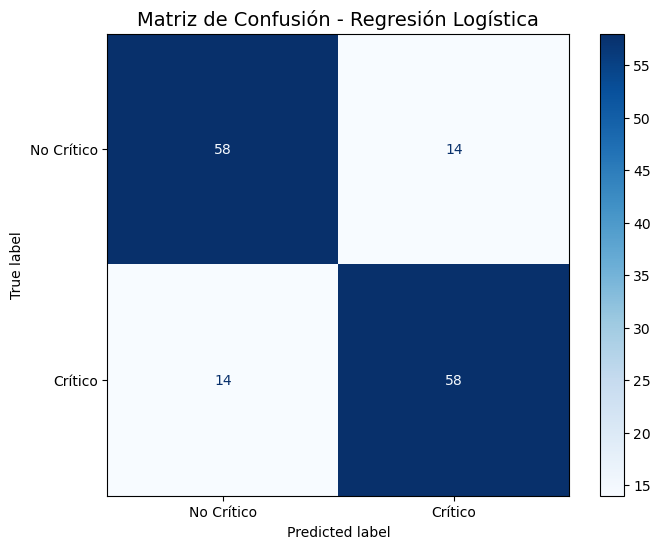


Mostrando Curva Precisión-Recall...


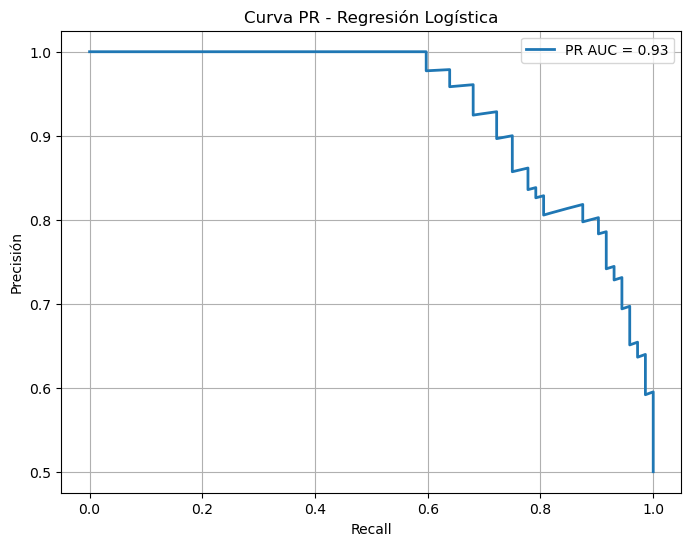


--- Métrica de Ranking: Recall@k ---
Recall@10: 13.89% (10 de 72 críticos encontrados)
Recall@20: 27.78% (20 de 72 críticos encontrados)
Recall@30: 41.67% (30 de 72 críticos encontrados)
Recall@50: 66.67% (48 de 72 críticos encontrados)

--- Entrenando y Guardando Modelo: Naive Bayes ---
✅ Modelo de Naive Bayes guardado como 'pipeline_naive_bayes.pkl'

 EVALUACIÓN AVANZADA DEL MODELO: Naive Bayes

--- Reporte de Clasificación ---
                precision    recall  f1-score   support

No Crítico (0)       0.88      0.78      0.82        72
   Crítico (1)       0.80      0.89      0.84        72

      accuracy                           0.83       144
     macro avg       0.84      0.83      0.83       144
  weighted avg       0.84      0.83      0.83       144


Mostrando Matriz de Confusión...


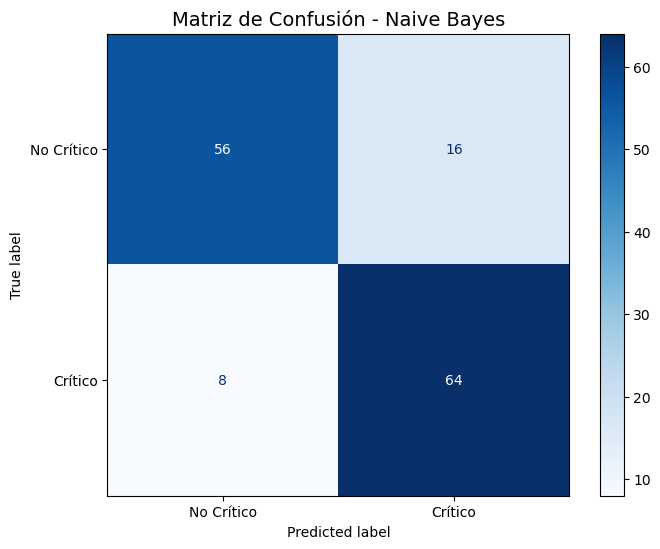


Mostrando Curva Precisión-Recall...


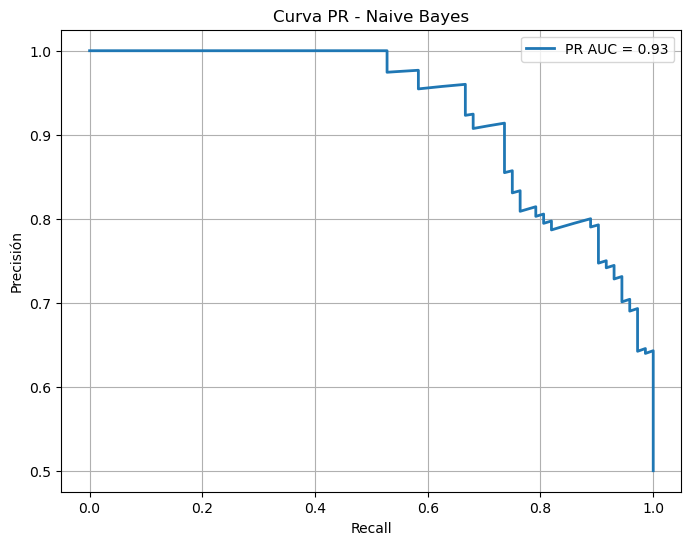


--- Métrica de Ranking: Recall@k ---
Recall@10: 13.89% (10 de 72 críticos encontrados)
Recall@20: 27.78% (20 de 72 críticos encontrados)
Recall@30: 41.67% (30 de 72 críticos encontrados)
Recall@50: 66.67% (48 de 72 críticos encontrados)


In [11]:
#  1. PREPARACIÓN DEL ENTORNO 
# Importamos todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay)
import os
import string
import nltk
import unicodedata
import joblib

# Descargar y definir las 'stopwords'
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

#  2. FUNCIONES
def crear_dataset_desde_carpetas(ruta_no_criticos, ruta_criticos):
    textos, etiquetas = [], []
    for dirpath, _, filenames in os.walk(ruta_no_criticos):
        for fname in filenames:
            if fname.endswith(".txt"):
                with open(os.path.join(dirpath, fname), 'r', encoding='utf-8') as f:
                    textos.append(f.read()); etiquetas.append(0)
    for dirpath, _, filenames in os.walk(ruta_criticos):
        for fname in filenames:
            if fname.endswith(".txt"):
                with open(os.path.join(dirpath, fname), 'r', encoding='utf-8') as f:
                    textos.append(f.read()); etiquetas.append(1)
    return pd.DataFrame({'texto': textos, 'etiqueta': etiquetas})

def remover_acentos(texto):
    forma_nfd = unicodedata.normalize('NFD', texto)
    return "".join([c for c in forma_nfd if not unicodedata.combining(c)])

def preprocess_text(text):
    text = text.lower()
    text = remover_acentos(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

def evaluacion_avanzada(nombre_modelo, y_true, y_pred, y_probs):
    print("\n" + "="*60)
    print(f" EVALUACIÓN AVANZADA DEL MODELO: {nombre_modelo}")
    print("="*60)
    
    # 1. Reporte de Clasificación
    print("\n--- Reporte de Clasificación ---")
    print(classification_report(y_true, y_pred, target_names=['No Crítico (0)', 'Crítico (1)']))
    
    # 2. Matriz de Confusión
    print("\nMostrando Matriz de Confusión...")
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, display_labels=['No Crítico', 'Crítico'], cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo}', fontsize=14)
    plt.show()
    
    # 3. Curva PR
    print("\nMostrando Curva Precisión-Recall...")
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall'); plt.ylabel('Precisión'); plt.title(f'Curva PR - {nombre_modelo}'); plt.legend(); plt.grid(True); plt.show()
    
    # 4. Recall@k
    def calculate_recall_at_k(y_true_k, y_scores_k, k):
        desc_score_indices = np.argsort(y_scores_k, kind="mergesort")[::-1]
        top_k_indices = desc_score_indices[:k]
        num_positives = np.sum(y_true_k.iloc[top_k_indices])
        total_positives = np.sum(y_true_k)
        return num_positives / total_positives if total_positives > 0 else 0
        
    print("\n--- Métrica de Ranking: Recall@k ---")
    total_criticos = np.sum(y_true)
    for k in [10, 20, 30, 50]:
        if k <= len(y_true):
            recall_k = calculate_recall_at_k(y_true, pd.Series(y_probs), k)
            encontrados = int(recall_k * total_criticos)
            print(f"Recall@{k}: {recall_k:.2%} ({encontrados} de {total_criticos} críticos encontrados)")


# 3. CARGA Y PREPROCESAMIENTO DE DATOS
CARPETA_NO_CRITICOS = 'Informes_Anonimizados/no_criticos'
CARPETA_CRITICOS = 'Informes_Anonimizados/criticos'
df = crear_dataset_desde_carpetas(CARPETA_NO_CRITICOS, CARPETA_CRITICOS)
df['texto_limpio'] = df['texto'].apply(preprocess_text)


# 4. DIVISIÓN Y VECTORIZACIÓN
X = df['texto_limpio']
y = df['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# GUARDAR EL CONJUNTO DE PRUEBA PARA EVALUAR MEJORAS EN ARCHIVO (Evalua_analiza_error)
joblib.dump((X_test, y_test), 'datos_de_prueba.pkl')
print("\n Datos de prueba (X_test, y_test) guardados en 'datos_de_prueba.pkl'")


# 5. ENTRENAMIENTO, GUARDADO Y EVALUACIÓN DE MODELOS

# -Modelo 1: Regresión Logística
print("\n--- Entrenando y Guardando Modelo: Regresión Logística ---")
pipeline_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])
pipeline_lr.fit(X_train, y_train)
joblib.dump(pipeline_lr, 'pipeline_regresion_logistica.pkl')
print(" Modelo de Regresión Logística guardado como 'pipeline_regresion_logistica.pkl'")
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_probs_lr = pipeline_lr.predict_proba(X_test)[:, 1]
evaluacion_avanzada("Regresión Logística", y_test, y_pred_lr, y_pred_probs_lr)


# -Modelo 2: Naive Bayes
print("\n--- Entrenando y Guardando Modelo: Naive Bayes ---")
pipeline_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)
joblib.dump(pipeline_nb, 'pipeline_naive_bayes.pkl')
print(" Modelo de Naive Bayes guardado como 'pipeline_naive_bayes.pkl'")
y_pred_nb = pipeline_nb.predict(X_test)
y_pred_probs_nb = pipeline_nb.predict_proba(X_test)[:, 1]
evaluacion_avanzada("Naive Bayes", y_test, y_pred_nb, y_pred_probs_nb)